In [15]:
import pandas as pd
import numpy as np

In [16]:
df_nr = pd.read_csv(
            "nr_pdb_filtered.blast.tsv", 
            sep="\t", 
            names=("qid", "tid", "pidentity", "aln_len", "mismatches", "qlen", "tlen", "perc_q_cov_per_hsp", "evalue", "bitscore"),
            comment="#"
        )

In [17]:
df_nr = df_nr[df_nr.qid!=df_nr.tid]

In [18]:
qlen = df_nr['qlen'].values
tlen = df_nr['tlen'].values
qt_len_pairs = np.vstack((qlen, tlen)).transpose()

In [19]:
len_cov = np.array([min(x)/max(x) for x in qt_len_pairs])

In [44]:
MIN_LEN_COV = 0.80
MIN_PID = 30

df_hi_pid = df_nr[(len_cov>MIN_LEN_COV) & (df_nr.pidentity>MIN_PID)]

In [45]:
df_hi_pid.head()

qid      tid  pidentity  aln_len  mismatches  qlen  tlen  \
1  4v7h_BF  3j6x_L7     86.735      196          26   213   244   
2  4v7h_BF  5ndv_L7     86.735      196          26   213   226   
3  4v7h_BF  4u3m_L7     86.735      196          26   213   243   
4  4v7h_BF  5i4l_L7     86.735      196          26   213   223   
5  4v7h_BF  5m1j_F5     86.735      196          26   213   222   

   perc_q_cov_per_hsp         evalue  bitscore  
1                  92  3.430000e-125     354.0  
2                  92  4.430000e-125     353.0  
3                  92  5.360000e-125     353.0  
4                  92  7.770000e-125     352.0  
5                  92  9.450000e-125     352.0

In [46]:
"{:,}".format(len(df_hi_pid))

'6,367,729'

In [54]:
qids = df_hi_pid.qid.values
tids = df_hi_pid.tid.values


all_ids = np.append(qids, tids)
all_ids = np.array([x.split("_")[0] for x in all_ids])
all_ids = np.unique(all_ids)

with open("PDB_FILES_X.TSV", "w+") as f:
    for pdbid in all_ids:
        f.write("https://files.rcsb.org/download/{}.cif\n".format(pdbid))
        break

In [53]:
len(all_ids)

80728

In [47]:
df_hi_pid.evalue.describe()

count     6.367729e+06
mean      3.296124e-09
std       4.012362e-08
min       0.000000e+00
25%      3.010000e-122
50%       4.310000e-93
75%       1.630000e-44
max       1.000000e-06
Name: evalue, dtype: float64

<AxesSubplot:>

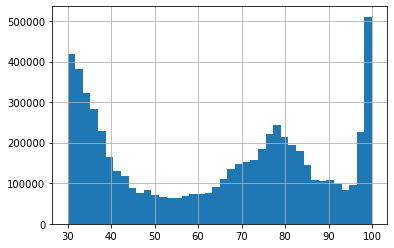

In [48]:
df_hi_pid.pidentity.hist(bins=40)

## Get experimental method in CIF file: XRAY, NMR vs

In [ ]:
fgrep "_exptl.method " ../cif/*.cif > METHOD.TXT

cat METHOD.TXT | tr "/" "\t" | \
    tr "." "\t" | tr -s " " | \
    sed -r 's/[ ]+/\t/'| sed 's/method /\t/' | \
    tr -s "\t" | cut -f3,6 | tr -d "'" \
    sed -r 's/[ ]+$//' > PDB_ID_vs_METHOD.TSV

mv METHOD.TXT .backup/

In [37]:
df_methods = pd.read_csv("PDB_ID_vs_METHOD.TSV", sep="\t", names=("PDB_ID", "method")) 

In [40]:
xray_ids = set(df_methods[df_methods.method == 'X-RAY DIFFRACTION'].PDB_ID.values)

## Write valid pairs to text file

In [42]:
with open("PDB_PAIRS.TSV", "w+") as f:
    for i, row in df_hi_pid.iterrows():
        p1 = row.qid.split("_")
        p2 = row.tid.split("_")
        
        id1 = p1[0]
        id2 = p2[0]        
        
        # Only write structures from Xray experiments
        if (id1 in xray_ids) and (id2 in xray_ids):        
            subchain1 = p1[1]
            subchain2 = p2[1]        
        
            f.write("{}\t{}\t{}\t{}\n".format(id1, subchain1, id2, subchain2))

In [20]:
!cat PDB_PAIRS.TSV | cut -f1,3 | tr "\t" "\n" | sort | uniq | awk '{print "https://files.rcsb.org/download/"$1".cif"}' > PDB_FILES.TXT